In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

┌ Info: Precompiling Alphabeta [1981c01b-18a7-44d8-b572-49586e674f9d]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [69]:
Nh = 128    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Build GMM, $p_{\rm eq}(x)=0.5 \mathcal {N}(\mu_1 ,\sigma_1 ^{2})+ 0.5\mathcal {N}(\mu_2 ,\sigma_2 ^{2})$

In [70]:
μ1 = 45.
σ1 = 1.0
normal1 = gaussian(xref[:,1], μ1, σ1)
μ2 = 55.
σ2 = 1.0
normal2 = gaussian(xref[:,1], μ2, σ2);
peq = normal1 .+ normal2
peq = peq / sum(w0 .* peq)
peq = max.(peq, 1e-10);

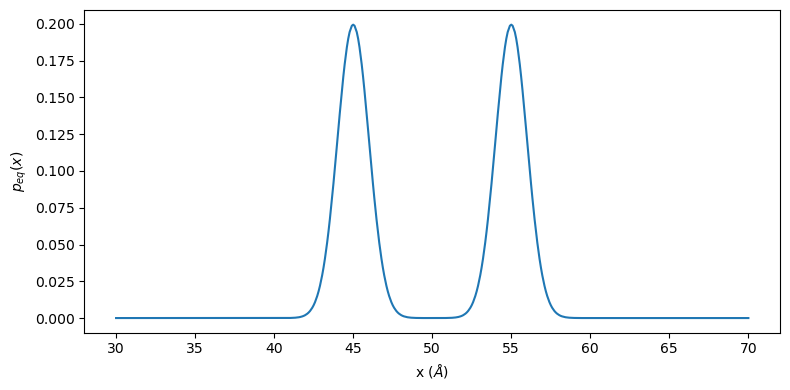

In [71]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, peq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")

plt.tight_layout()
#plt.savefig("Gaussian_Kde_harmonic_well.svg")
plt.show()

### Part 3: Eigendecomposition for KDE estimation

In [72]:
D = 4.845e9; # Diffusion coefficient, unit: angstrom^2 s-1
Nv = 72 # Number of eigenvectors
LQ, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq, D, Nv);

Inspect 1-12 eigenvectors

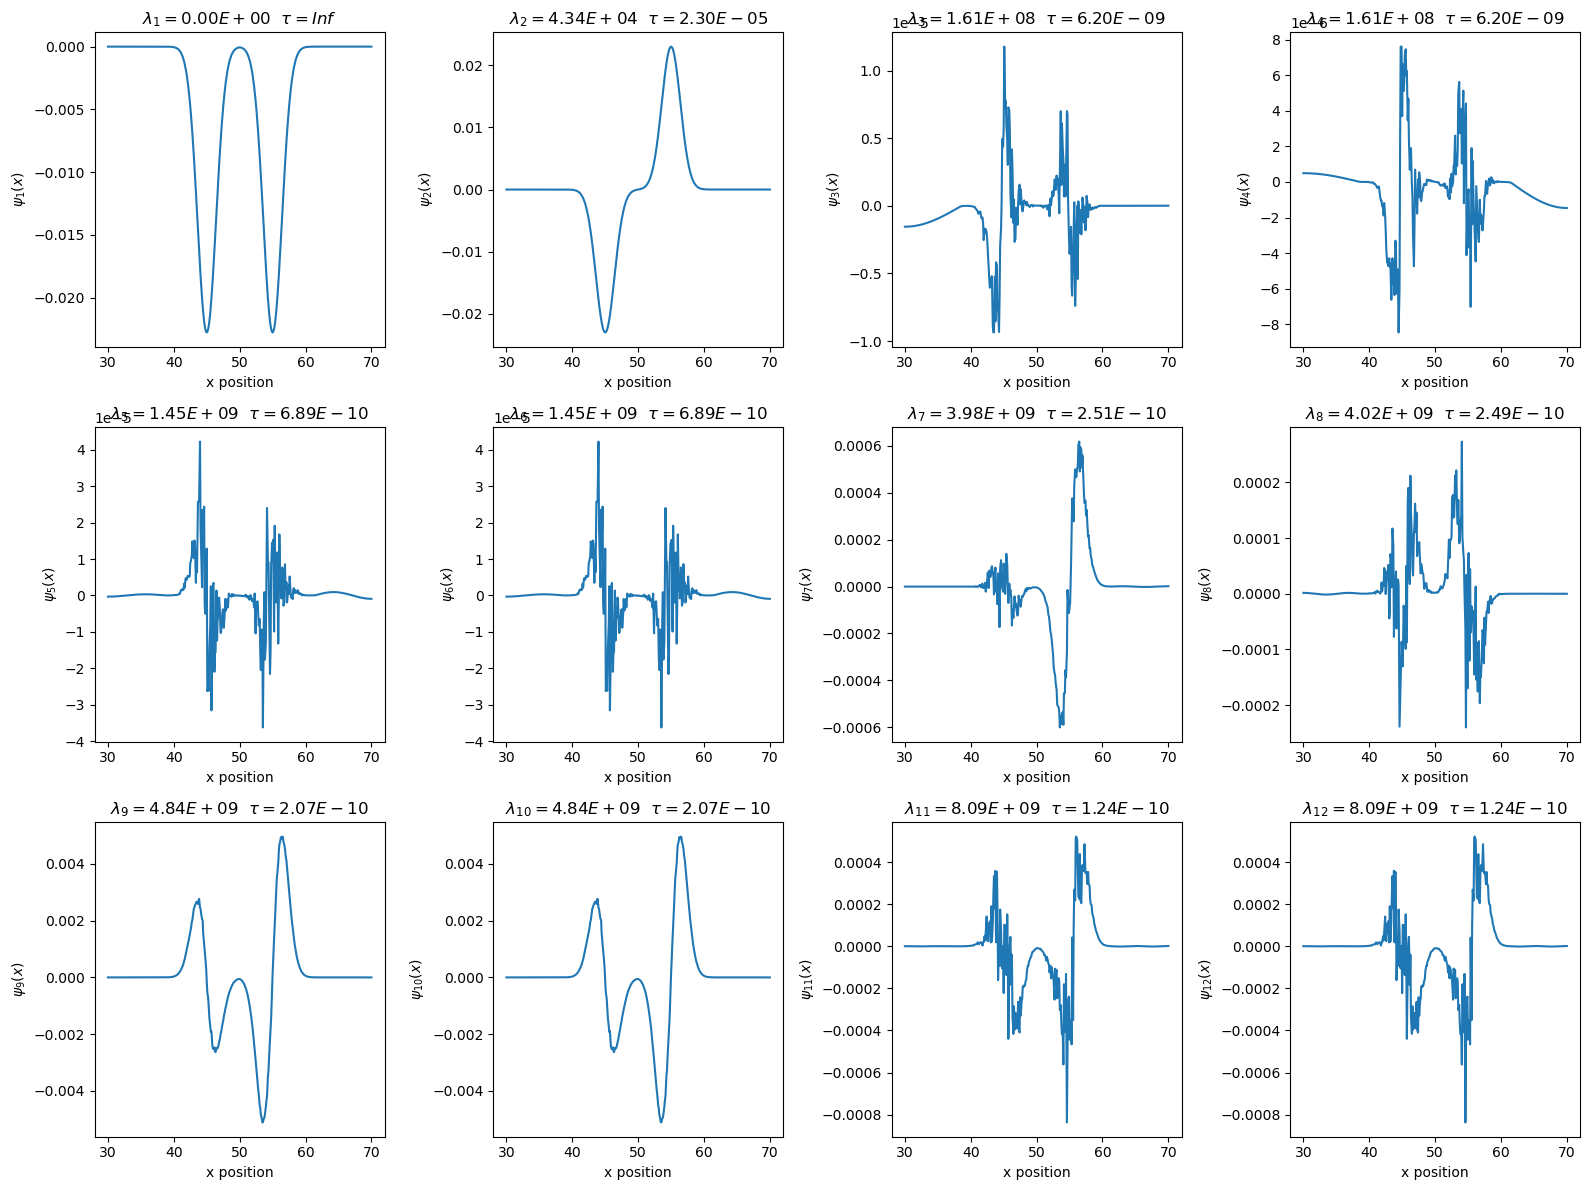

In [73]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,12))

idx_eigvector = 1
for row_id=1:3
    for col_id = 1:4
        ax = axes[row_id, col_id]
        plot_x_Qx_lambda(ax, idx_eigvector, LQ, Qx, xref)
        idx_eigvector += 1
    end
end
plt.tight_layout()
#plt.savefig("eigv_1_12.png", dpi=150)
plt.show()

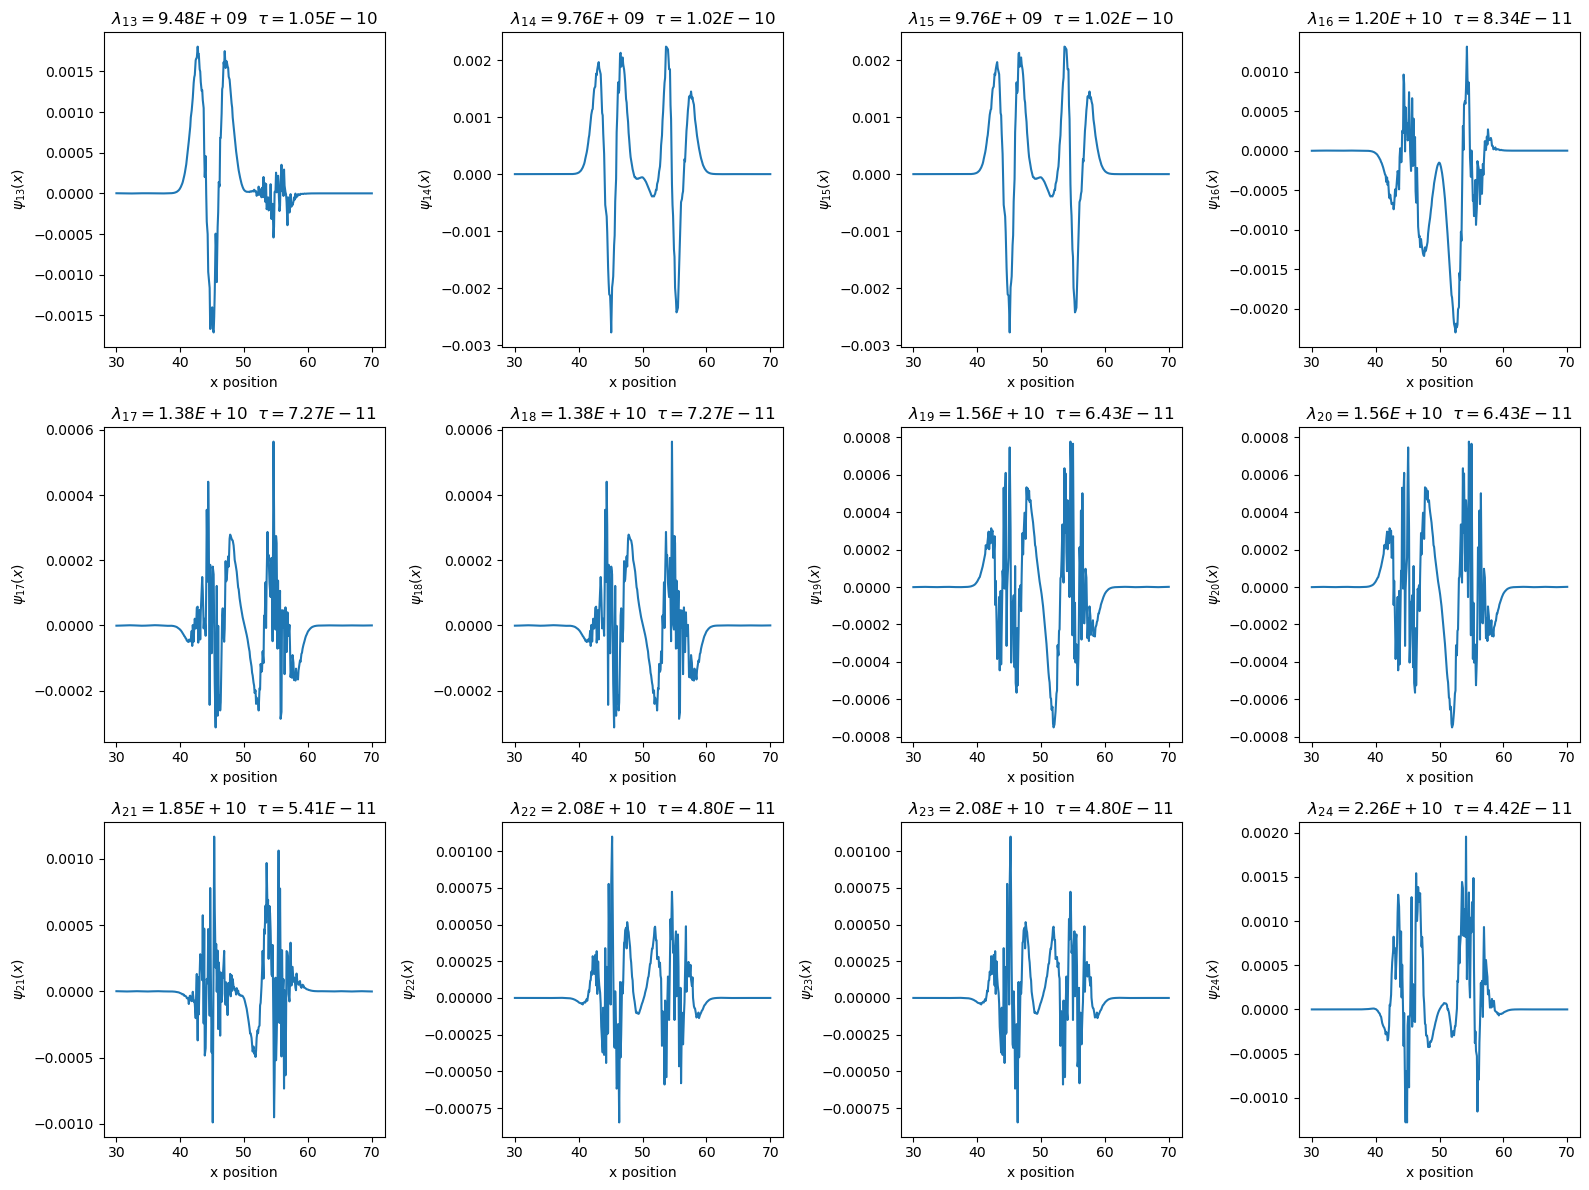

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16,12))

idx_eigvector = 13
for row_id=1:3
    for col_id = 1:4
        ax = axes[row_id, col_id]
        plot_x_Qx_lambda(ax, idx_eigvector, LQ, Qx, xref)
        idx_eigvector += 1
    end
end
plt.tight_layout()
#plt.savefig("eigv_1_12.png", dpi=150)
plt.show()

### Part 6: EM-1

In [10]:
p_em_1, log_likelihood = forward_backward_v2(Nh, Np, xratio, xavg, peq_kde_estimate, D, Nv, tau, y_record, save_freq);

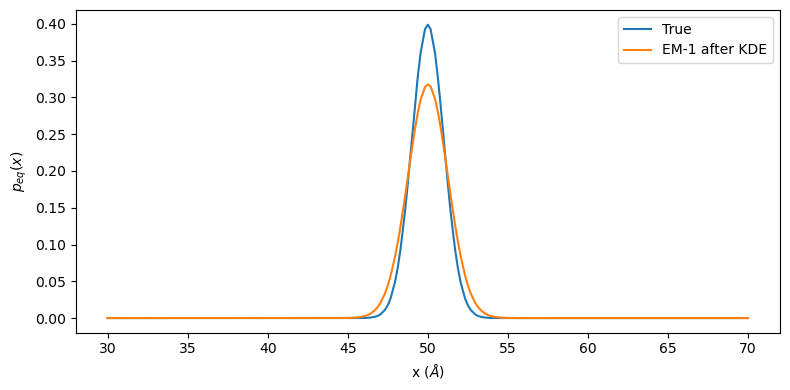

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, rho_eq .* rho_eq, label="True")
ax.plot(xref, p_em_1, label="EM-1 after KDE")
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()

plt.tight_layout()
plt.show()

### Part 7: EM-2

In [17]:
p_em_1 = max.(p_em_1, 1e-10)
p_prev = zeros(N, 1)
p_prev[:,1] = p_em_1;

In [19]:
p_em_2, log_likelihood = forward_backward_v2(Nh, Np, xratio, xavg, p_prev, D, Nv, tau, y_record, save_freq);

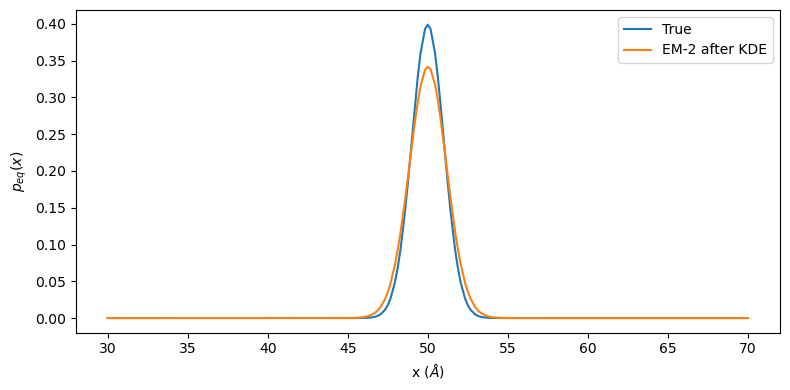

In [20]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, rho_eq .* rho_eq, label="True")
ax.plot(xref, p_em_2, label="EM-2 after KDE")
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.legend()

plt.tight_layout()
plt.show()

In [22]:
a = 50. # unit: Å
D = get_D_by_Stokes_Einstein_relation(a)

LoadError: UndefVarError: get_D_by_Stokes_Einstein_relation not defined